In [1]:
import posixpath
import numpy as np
import pandas as pd
import geopandas as gpd
import distances 
import matplotlib.pyplot as plt
import scipy

## Load Fronts

In [2]:
data_root = "D:/OneDrive/Documents/Cours/4A/SFE/data/"

kh_fronts = gpd.read_file(posixpath.join(data_root, "KH-5_ARGON_fronts/KH-5_ARGON_fronts.shp")).to_crs(epsg=25833)
landsat_fronts = gpd.read_file(posixpath.join(data_root, "Landsat_MSS_fronts/Landsat_MSS_fronts.shp")).to_crs(epsg=25833)
all_fronts = pd.concat([kh_fronts, landsat_fronts], ignore_index=True)
all_fronts.head()

,image,mission,timestamp,RGI60ID,RGI70ID,front_id,front_dir,geometry
0,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00777,RGI2000-v7.0-G-07-01225,3,E,"LINESTRING (447461.671 8832029.666, 447497.042..."
1,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00775,RGI2000-v7.0-G-07-01229,4,SE,"LINESTRING (446131.469 8835920.477, 446232.529..."
2,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00709,RGI2000-v7.0-G-07-00011,25,W,"LINESTRING (416080.008 8819152.093, 416146.96 ..."
3,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00664,RGI2000-v7.0-G-07-00015,26,W,"LINESTRING (415736.404 8813938.659, 415733.877..."
4,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00663,RGI2000-v7.0-G-07-00016,27,W,"LINESTRING (417320.52 8806789.925, 417358.417 ..."


## Results w/ manual distance

In [6]:
def get_year(timestamp):
    return timestamp.year

results = pd.DataFrame(
    [],
    columns = ["front_id", "year_1", "year_2", "distance"]
)
skip_count_len = 0
skip_count_dir = 0
total_count = 0
years = [1962, 1963, 1976, 1978]

for front in all_fronts.front_id.unique():
    # compare observations from any year to fronts from any other year, for a specific front.
    for i_year in range(len(years) - 1):
        year = years[i_year]
        fronts = all_fronts.loc[all_fronts.front_id == front].loc[all_fronts.timestamp.apply(get_year) == year]
        for i_other_year in range(i_year + 1, len(years)):
            other_year = years[i_other_year]
            other_fronts = all_fronts.loc[all_fronts.front_id == front].loc[all_fronts.timestamp.apply(get_year) == other_year]
            
            dists = []
            # compare all the observations between them
            for k in range(len(fronts.geometry)):
                for l in range(len(other_fronts.geometry)):
                    front1 = fronts.geometry.iloc[k]
                    front2 = other_fronts.geometry.iloc[l]
                    dir_1 = fronts.front_dir.iloc[k]
                    dir_2 = other_fronts.front_dir.iloc[l]
                    # print(front) # to identify the fronts that have different flow directions.
                    try:
                        dist, e = distances.distance(front1, front2, dir_1, dir_2)
                        if dist is not None: # recall: distance returns None if the lengths of the fronts are too different
                            dists.append(dist)
                        elif e == 1:
                            skip_count_len += 1
                        elif e == 2:
                            skip_count_dir += 1
                    except AssertionError:
                        skip_count_dir += 1
                    total_count += 1
            
            if not dists == []:
                # horrible hack to load an array as a value in a DataFrame
                results_i = pd.DataFrame(
                    [[front, year, other_year, np.array(dists)]],
                    columns=["front_id", "year_1", "year_2", "distance"]
                )      
            else: # load None instead of a list of distances
                results_i = pd.DataFrame(
                    [[front, year, other_year, None]],
                    columns=["front_id", "year_1", "year_2", "distance"]
                )
            results = pd.concat([results, results_i])
            
print(f"Skipped {skip_count_len + skip_count_dir} ({skip_count_dir} direction and {skip_count_len} length) comparisons out of {total_count}.")
results.reset_index(drop=True, inplace=True)
results = results.dropna().reset_index(drop=True)
results

Skipped 493 (47 direction and 446 length) comparisons out of 2019.


,front_id,year_1,year_2,distance
0,4,1962,1963,"[-86.23007513843609, -396.32188237109665]"
1,4,1962,1976,"[-1450.7132367907936, -1511.82316731564, -70.0..."
2,4,1963,1976,"[-422.5270542819276, -470.5395858628364, -310...."
3,25,1962,1963,"[52.934303303832884, -308.1062720617464, 223.5..."
4,25,1962,1976,"[76.82899443702789, 220.5166627894711]"
...,...,...,...,...
434,87,1976,1978,[-91.97451945462406]
435,82,1976,1978,[-153.44472935472436]
436,66,1976,1978,[-72.56704667293884]
437,72,1976,1978,[-33.72669053388882]


In [18]:
uncertainties = pd.read_csv("./uncertainties_manual.csv", dtype={"year_1": int, "year_2": int})
uncertainties.loc[:, "years"] = uncertainties.loc[:, ["year_1", "year_2"]].apply(lambda x: (x.iloc[0], x.iloc[1]), axis=1)
uncertainties

,year_1,year_2,sigma_dist,2_sigma_dist,3_sigma_dist,years
0,1962,1962,709.935208,1419.870417,2129.805625,"(1962, 1962)"
1,1962,1963,545.710546,1091.421092,1637.131638,"(1962, 1963)"
2,1962,1976,510.909973,1021.819945,1532.729918,"(1962, 1976)"
3,1962,1978,511.476295,1022.952589,1534.428884,"(1962, 1978)"
4,1963,1963,302.641702,605.283405,907.925107,"(1963, 1963)"
5,1963,1976,234.138848,468.277695,702.416543,"(1963, 1976)"
6,1963,1978,235.372046,470.744092,706.116138,"(1963, 1978)"
7,1976,1976,134.350288,268.700577,403.050865,"(1976, 1976)"
8,1976,1978,136.488095,272.976189,409.464284,"(1976, 1978)"


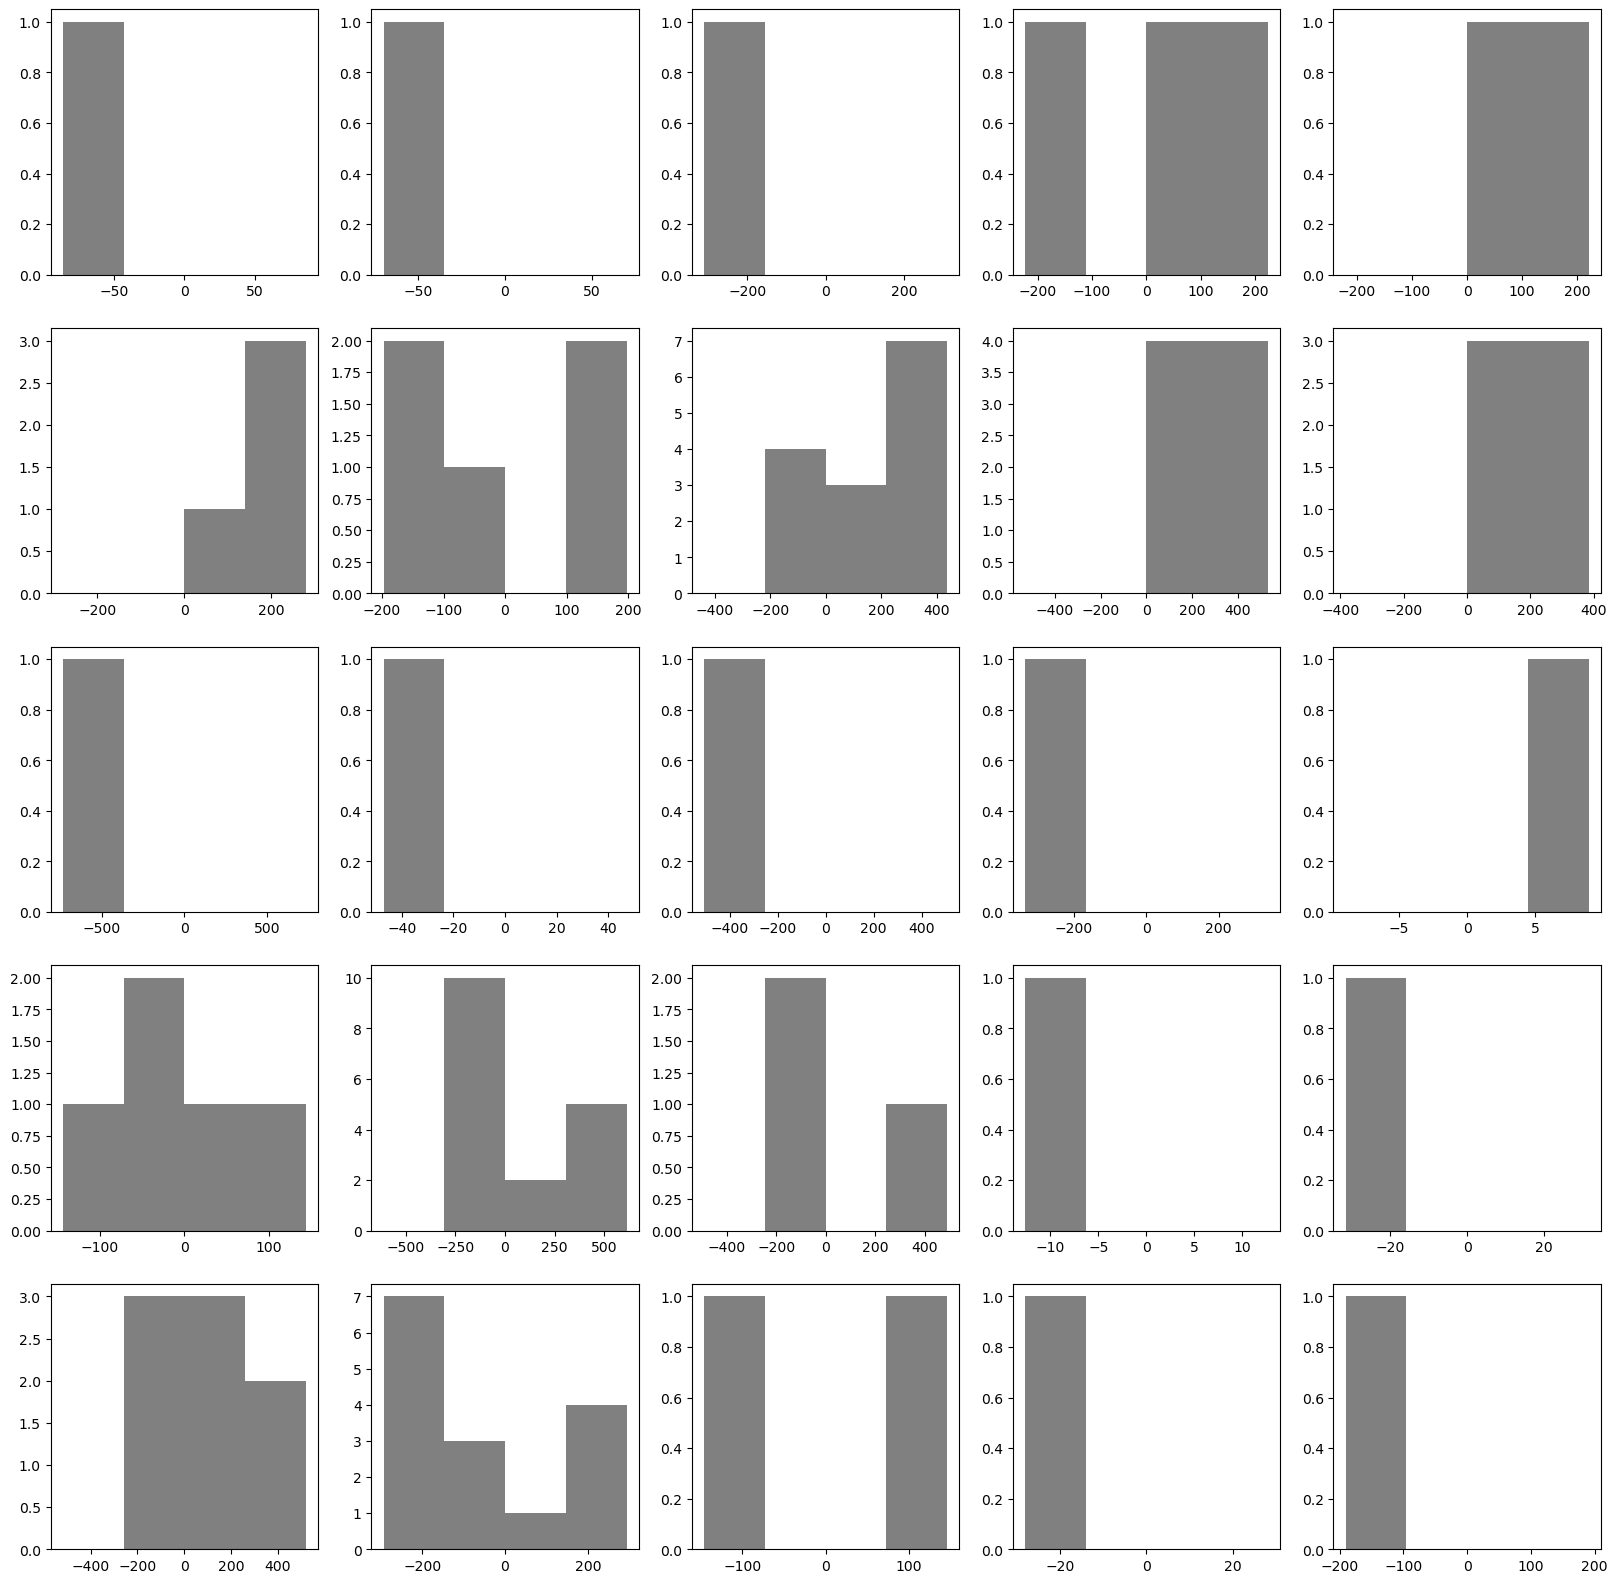

In [8]:
fig, axs = plt.subplots(ncols=5, nrows=5, figsize=[20, 20])
c = 0
for i in range(len(results)):
    if len(results.distance[i]) > 1:
        if c < 25:
            axs[c//5, c%5].hist(results.distance[i], bins=np.linspace(-np.abs(results.distance[i].max()), np.abs(results.distance[i].max()), 5), color="gray")
        c += 1

In [9]:
results.loc[:, "mean_distance"] = results.distance.apply(lambda x: np.array(x).mean())
results.loc[:, "uncertainty"] = results.loc[:, ["year_1", "year_2"]].apply(lambda x: uncertainties.loc[(uncertainties.year_1 == x.iloc[0]) & (uncertainties.year_2 == x.iloc[1]), "2_sigma_dist"].values[0], axis=1)

# not necessary but easier to control results : put the years in a single column. 
results.loc[:, "years"] = results.loc[:, ["year_1", "year_2"]].apply(lambda x: (x.iloc[0], x.iloc[1]), axis=1)
results = results[["front_id", "year_1", "year_2", "years", "distance", "mean_distance", "uncertainty"]]

results

,front_id,year_1,year_2,years,distance,mean_distance,uncertainty
0,4,1962,1963,"(1962, 1963)","[-86.23007513843609, -396.32188237109665]",-241.275979,1091.421092
1,4,1962,1976,"(1962, 1976)","[-1450.7132367907936, -1511.82316731564, -70.0...",-924.789543,1021.819945
2,4,1963,1976,"(1963, 1976)","[-422.5270542819276, -470.5395858628364, -310....",-664.223629,468.277695
3,25,1962,1963,"(1962, 1963)","[52.934303303832884, -308.1062720617464, 223.5...",-39.310605,1091.421092
4,25,1962,1976,"(1962, 1976)","[76.82899443702789, 220.5166627894711]",148.672829,1021.819945
...,...,...,...,...,...,...,...
434,87,1976,1978,"(1976, 1978)",[-91.97451945462406],-91.974519,272.976189
435,82,1976,1978,"(1976, 1978)",[-153.44472935472436],-153.444729,272.976189
436,66,1976,1978,"(1976, 1978)",[-72.56704667293884],-72.567047,272.976189
437,72,1976,1978,"(1976, 1978)",[-33.72669053388882],-33.726691,272.976189


In [10]:
# horrible way to plot a summary of the results, but I could not find better.
results_overview = pd.DataFrame(
    [],
    columns=["years", "uncertainty", "count"]
)
results_overview.loc[:, "years"] = results.years.unique()
results_overview.loc[:, "uncertainty"] = results.uncertainty.unique()
results_overview.loc[:, "count"] = results.years.value_counts().values
results_overview

,years,uncertainty,count
0,"(1962, 1963)",1091.421092,100
1,"(1962, 1976)",1021.819945,94
2,"(1963, 1976)",468.277695,68
3,"(1963, 1978)",470.744092,65
4,"(1976, 1978)",272.976189,62
5,"(1962, 1978)",1022.952589,50


62 -25.64493951798229 202.68955163617233
100 -144.3029461553655 577.9798141277005
68 -103.46106983241184 714.7724608579525
65 -242.87406537842466 638.818181857793
50 -195.08917853911626 739.0742261257744
94 -56.48980003531667 149.42638623089078


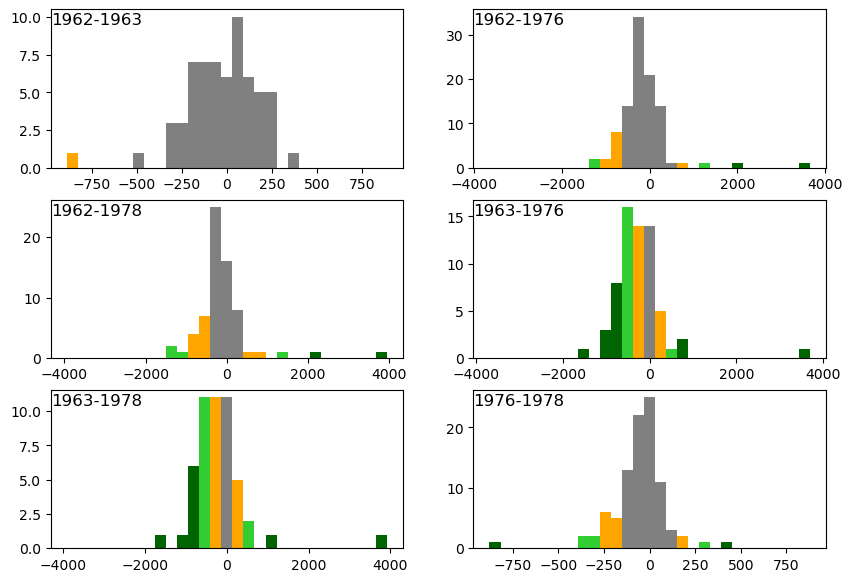

In [11]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(10, 7))

color_sigma = "orange"
color_2_sigma = "limegreen"
color_3_sigma = "darkgreen"
nbins = 30

years = (1962, 1963)
d = results.loc[results.years == years].mean_distance
N, bins, patches = axs[0, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties.loc[uncertainties.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2  # shift bins to the center
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[0, 0].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1962, 1976)
d = results.loc[results.years == years].mean_distance
N, bins, patches = axs[0, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties.loc[uncertainties.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[0, 1].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1962, 1978)
d = results.loc[results.years == years].mean_distance
N, bins, patches = axs[1, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties.loc[uncertainties.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[1, 0].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1963, 1976)
d = results.loc[results.years == years].mean_distance
N, bins, patches = axs[1, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties.loc[uncertainties.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[1, 1].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1963, 1978)
d = results.loc[results.years == years].mean_distance
N, bins, patches = axs[2, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties.loc[uncertainties.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[2, 0].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1976, 1978)
d = results.loc[results.years == years].mean_distance
N, bins, patches = axs[2, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties.loc[uncertainties.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[2, 1].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())
fig.savefig("images/results_distances_distributions.png", bbox_inches="tight")

62 -25.64493951798229 202.68955163617233
100 -144.3029461553655 577.9798141277005
68 -103.46106983241184 714.7724608579525
65 -242.87406537842466 638.818181857793
50 -195.08917853911626 739.0742261257744
94 -56.48980003531667 149.42638623089078


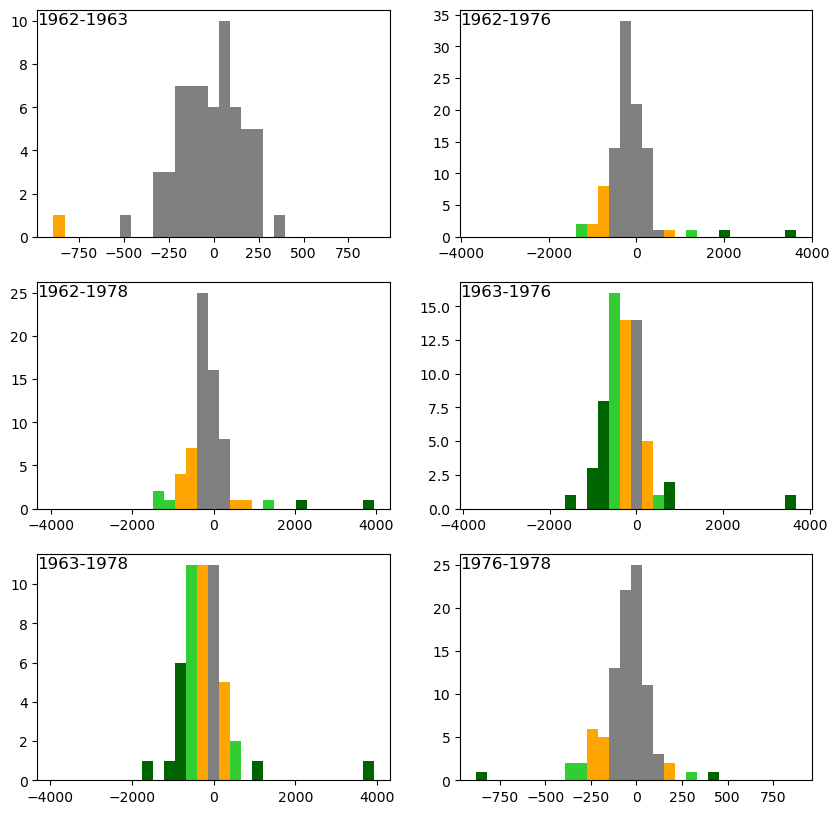

In [12]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(10, 10))

color_sigma = "orange"
color_2_sigma = "limegreen"
color_3_sigma = "darkgreen"
nbins = 30

years = (1962, 1963)
d = results.loc[results.years == years].mean_distance
N, bins, patches = axs[0, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties.loc[uncertainties.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2  # shift bins to the center
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[0, 0].set_title(f"{years[0]}-{years[1]}", y=0.9, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1962, 1976)
d = results.loc[results.years == years].mean_distance
N, bins, patches = axs[0, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties.loc[uncertainties.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[0, 1].set_title(f"{years[0]}-{years[1]}", y=0.9, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1962, 1978)
d = results.loc[results.years == years].mean_distance
N, bins, patches = axs[1, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties.loc[uncertainties.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[1, 0].set_title(f"{years[0]}-{years[1]}", y=0.9, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1963, 1976)
d = results.loc[results.years == years].mean_distance
N, bins, patches = axs[1, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties.loc[uncertainties.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[1, 1].set_title(f"{years[0]}-{years[1]}", y=0.9, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1963, 1978)
d = results.loc[results.years == years].mean_distance
N, bins, patches = axs[2, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties.loc[uncertainties.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[2, 0].set_title(f"{years[0]}-{years[1]}", y=0.9, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1976, 1978)
d = results.loc[results.years == years].mean_distance
N, bins, patches = axs[2, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties.loc[uncertainties.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[2, 1].set_title(f"{years[0]}-{years[1]}", y=0.9, loc="left")
print(d.shape[0], d.mean(), d.std())
fig.savefig("images/results_distances_distributions_big.png", bbox_inches="tight")

In [13]:
# list of surges and retreats

surges = pd.DataFrame(
    [],
    columns=["front_id", "years", "mean_distance", "uncertainty"]
)

retreats = pd.DataFrame(
    [],
    columns=["front_id", "years", "mean_distance", "uncertainty"]
)

for years in [(1962, 1963), (1962, 1976), (1962, 1978), (1963, 1976), (1963, 1978), (1976, 1978)]:
    # print("years :", years)
    sigma = uncertainties.loc[uncertainties.years == years]["sigma_dist"].values[0]
    res = results.where(results.loc[results.years == years, "mean_distance"].apply(lambda x: np.abs(x) >= 2 * sigma)).dropna().loc[:, ["front_id", "years", "mean_distance", "uncertainty"]]
    # print(res)
    surges_1 = res.where(res.mean_distance.apply(lambda x: x >= 0)).dropna()
    retreats_1 = res.where(res.mean_distance.apply(lambda x: x < 0)).dropna()
    if not surges_1.empty:
        surges = pd.concat([surges, surges_1])
    if not retreats_1.empty:
        retreats = pd.concat([retreats, retreats_1])
        
surges

C:\Users\loris\AppData\Local\Temp\ipykernel_4536\2778544960.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  surges = pd.concat([surges, surges_1])
C:\Users\loris\AppData\Local\Temp\ipykernel_4536\2778544960.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  retreats = pd.concat([retreats, retreats_1])


,front_id,years,mean_distance,uncertainty
253,122,"(1962, 1976)",3652.623886,1021.819945
307,121,"(1962, 1976)",1962.144474,1021.819945
350,123,"(1962, 1976)",1312.976490,1021.819945
254,122,"(1962, 1978)",3943.133563,1022.952589
308,121,"(1962, 1978)",2084.629828,1022.952589
351,123,"(1962, 1978)",1280.833637,1022.952589
116,56,"(1963, 1976)",719.102820,468.277695
193,91,"(1963, 1976)",626.482327,468.277695
255,122,"(1963, 1976)",3689.328406,468.277695
401,93,"(1963, 1976)",750.657229,468.277695


In [14]:
retreats

,front_id,years,mean_distance,uncertainty
42,37,"(1962, 1976)",-1211.339623,1021.819945
396,73,"(1962, 1976)",-1241.139226,1021.819945
43,37,"(1962, 1978)",-1436.924820,1022.952589
269,154,"(1962, 1978)",-1316.596948,1022.952589
357,109,"(1962, 1978)",-1147.300764,1022.952589
2,4,"(1963, 1976)",-664.223629,468.277695
10,28,"(1963, 1976)",-909.392141,468.277695
44,37,"(1963, 1976)",-1405.024328,468.277695
50,38,"(1963, 1976)",-628.615979,468.277695
65,41,"(1963, 1976)",-574.854364,468.277695


In [15]:
# list of all fronts that either surged or retreated with >95% accuracy
len(surges.front_id.unique()), surges.front_id.unique(), len(retreats.front_id.unique()), retreats.front_id.unique()

(8,
 array([122, 121, 123, 56, 91, 93, 120, 165], dtype=object),
 32,
 array([37, 73, 154, 109, 4, 28, 38, 41, 50, 51, 52, 53, 54, 58, 59, 141,
        161, 139, 140, 142, 160, 42, 95, 96, 97, 49, 2, 61, 76, 74, 93, 89],
       dtype=object))

## Results w/ box distance

In [16]:
boxes = gpd.read_file(posixpath.join(data_root, "boxes/boxes.shp")).to_crs(epsg=25833)
boxes.head()

,front_id,front_dir,RGI60ID,RGI70ID,geometry
0,1,NE,RGI60-07.01494,RGI2000-v7.0-G-07-00054,"POLYGON ((448958.093 8831407.133, 451132.965 8..."
1,2,NE,RGI60-07.00791,RGI2000-v7.0-G-07-01223,"POLYGON ((448556.464 8831393.624, 447609.196 8..."
2,3,E,RGI60-07.00777,RGI2000-v7.0-G-07-01225,"POLYGON ((446223.949 8833013.329, 449012.234 8..."
3,4,SE,RGI60-07.00775,RGI2000-v7.0-G-07-01229,"POLYGON ((445849.929 8838239.577, 448611.174 8..."
4,5,NE,RGI60-07.00794,RGI2000-v7.0-G-07-01268,"POLYGON ((444478.132 8842149.605, 443352.455 8..."


In [20]:
uncertainties_box = pd.read_csv("./uncertainties_box.csv", dtype={"year_1": int, "year_2": int})
uncertainties_box.loc[:, "years"] = uncertainties_box.loc[:, ["year_1", "year_2"]].apply(lambda x: (x.iloc[0], x.iloc[1]), axis=1)
uncertainties_box

,year_1,year_2,sigma_dist,2_sigma_dist,3_sigma_dist,years
0,1962,1962,709.935208,1419.870417,2129.805625,"(1962, 1962)"
1,1962,1963,545.710546,1091.421092,1637.131638,"(1962, 1963)"
2,1962,1976,510.909973,1021.819945,1532.729918,"(1962, 1976)"
3,1962,1978,511.476295,1022.952589,1534.428884,"(1962, 1978)"
4,1963,1963,302.641702,605.283405,907.925107,"(1963, 1963)"
5,1963,1976,234.138848,468.277695,702.416543,"(1963, 1976)"
6,1963,1978,235.372046,470.744092,706.116138,"(1963, 1978)"
7,1976,1976,134.350288,268.700577,403.050865,"(1976, 1976)"
8,1976,1978,136.488095,272.976189,409.464284,"(1976, 1978)"


In [21]:
results_box = pd.DataFrame(
    [],
    columns = ["front_id", "year_1", "year_2", "distance"]
)
total_count = 0
skip_count = 0
years = [1962, 1963, 1976, 1978]

for front in all_fronts.front_id.unique():
    # compare observations from any year to fronts from any other year, for a specific front.
    for i_year in range(len(years) - 1):
        year = years[i_year]
        fronts = all_fronts.loc[all_fronts.front_id == front].loc[all_fronts.timestamp.apply(get_year) == year]
        for i_other_year in range(i_year + 1, len(years)):
            other_year = years[i_other_year]
            other_fronts = all_fronts.loc[all_fronts.front_id == front].loc[all_fronts.timestamp.apply(get_year) == other_year]
            
            dists = []
            # compare all the observations between them
            for k in range(len(fronts.geometry)):
                for l in range(len(other_fronts.geometry)):
                    front1 = fronts.geometry.iloc[k]
                    front2 = other_fronts.geometry.iloc[l]
                    dir_1 = fronts.front_dir.iloc[k]
                    dir_2 = other_fronts.front_dir.iloc[l]
                    try:
                        if not boxes.loc[boxes.front_id == fronts.front_id.iloc[k]].empty:
                            box = boxes.loc[boxes.front_id == fronts.front_id.iloc[k]].geometry.values[0]
                            dist, e = distances.box_distance(front1, front2, box, dir_1, dir_2)
                            if dist is not None:
                                dists.append(dist)
                            elif e == 1:
                                skip_count += 1
                        else:
                            skip_count += 1
                    except AssertionError:
                        skip_count += 1
                    total_count += 1
            
            if not dists == []:
                # horrible hack to load an array as a value in a DataFrame
                results_i = pd.DataFrame(
                    [[front, year, other_year, np.array(dists)]],
                    columns=["front_id", "year_1", "year_2", "distance"]
                )      
            else: # load None instead of a list of distances
                results_i = pd.DataFrame(
                    [[front, year, other_year, None]],
                    columns=["front_id", "year_1", "year_2", "distance"]
                )
            results_box = pd.concat([results_box, results_i])
            
print(f"Skipped {skip_count} comparisons out of {total_count}.")
results_box.reset_index(drop=True, inplace=True)
results_box = results_box.dropna().reset_index(drop=True)


results_box.loc[:, "mean_distance"] = results_box.distance.apply(lambda x: np.array(x).mean())
results_box.loc[:, "uncertainty"] = results_box.loc[:, ["year_1", "year_2"]].apply(lambda x: uncertainties_box.loc[(uncertainties_box.year_1 == x.iloc[0]) & (uncertainties_box.year_2 == x.iloc[1]), "2_sigma_dist"].values[0], axis=1)

# not necessary but easier to control results : put the years in a single column. 
results_box.loc[:, "years"] = results_box.loc[:, ["year_1", "year_2"]].apply(lambda x: (x.iloc[0], x.iloc[1]), axis=1)
results_box = results_box[["front_id", "year_1", "year_2", "years", "distance", "mean_distance", "uncertainty"]]

results_box

Skipped 550 comparisons out of 2019.


,front_id,year_1,year_2,years,distance,mean_distance,uncertainty
0,3,1963,1976,"(1963, 1976)","[-341.26830933591924, -463.03829475751604]",-402.153302,468.277695
1,4,1963,1976,"(1963, 1976)","[-501.3441551864909, -545.3417011649898, -367....",-776.636692,468.277695
2,25,1962,1963,"(1962, 1963)","[104.29363221683396, 260.1996766181235]",182.246654,1091.421092
3,25,1962,1976,"(1962, 1976)","[251.13957302078396, 269.4042203817791, 81.303...",278.568870,1021.819945
4,25,1963,1976,"(1963, 1976)","[146.84594080395, 165.11058816494514, -22.9898...",96.322216,468.277695
...,...,...,...,...,...,...,...
435,65,1976,1978,"(1976, 1978)",[-114.31890299647765],-114.318903,272.976189
436,66,1976,1978,"(1976, 1978)",[-85.73270102390168],-85.732701,272.976189
437,72,1976,1978,"(1976, 1978)",[-36.90731420880558],-36.907314,272.976189
438,79,1976,1978,"(1976, 1978)",[-87.25323145609863],-87.253231,272.976189


In [22]:
results_box.value_counts("years")

years
(1962, 1976)    102
(1976, 1978)     89
(1962, 1978)     73
(1963, 1976)     70
(1962, 1963)     56
(1963, 1978)     50
Name: count, dtype: int64

56 -15.919301291419938 285.7828987448423
102 -285.23734828895147 815.2434204924118
73 -336.1466414434039 1025.12996197374
70 -294.4745160263729 965.4967540816172
50 -266.07918558537256 1092.0789001175115
89 -86.6713609533038 217.27608530068864


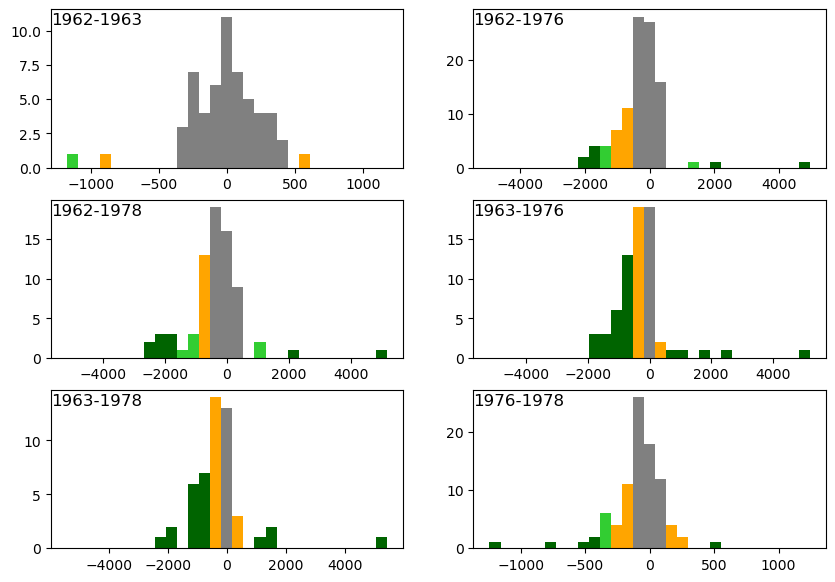

In [23]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(10, 7))

color_sigma = "orange"
color_2_sigma = "limegreen"
color_3_sigma = "darkgreen"
nbins = 30

years = (1962, 1963)
d = results_box.loc[results_box.years == years].mean_distance
N, bins, patches = axs[0, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2  # shift bins to the center
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[0, 0].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1962, 1976)
d = results_box.loc[results_box.years == years].mean_distance
N, bins, patches = axs[0, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[0, 1].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1962, 1978)
d = results_box.loc[results_box.years == years].mean_distance
N, bins, patches = axs[1, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[1, 0].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1963, 1976)
d = results_box.loc[results_box.years == years].mean_distance
N, bins, patches = axs[1, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[1, 1].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1963, 1978)
d = results_box.loc[results_box.years == years].mean_distance
N, bins, patches = axs[2, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[2, 0].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1976, 1978)
d = results_box.loc[results_box.years == years].mean_distance
N, bins, patches = axs[2, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[2, 1].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())
fig.savefig("images/results_distances_distributions_box.png", bbox_inches="tight")

56 -15.919301291419938 285.7828987448423
102 -285.23734828895147 815.2434204924118
73 -336.1466414434039 1025.12996197374
70 -294.4745160263729 965.4967540816172
50 -266.07918558537256 1092.0789001175115
89 -86.6713609533038 217.27608530068864


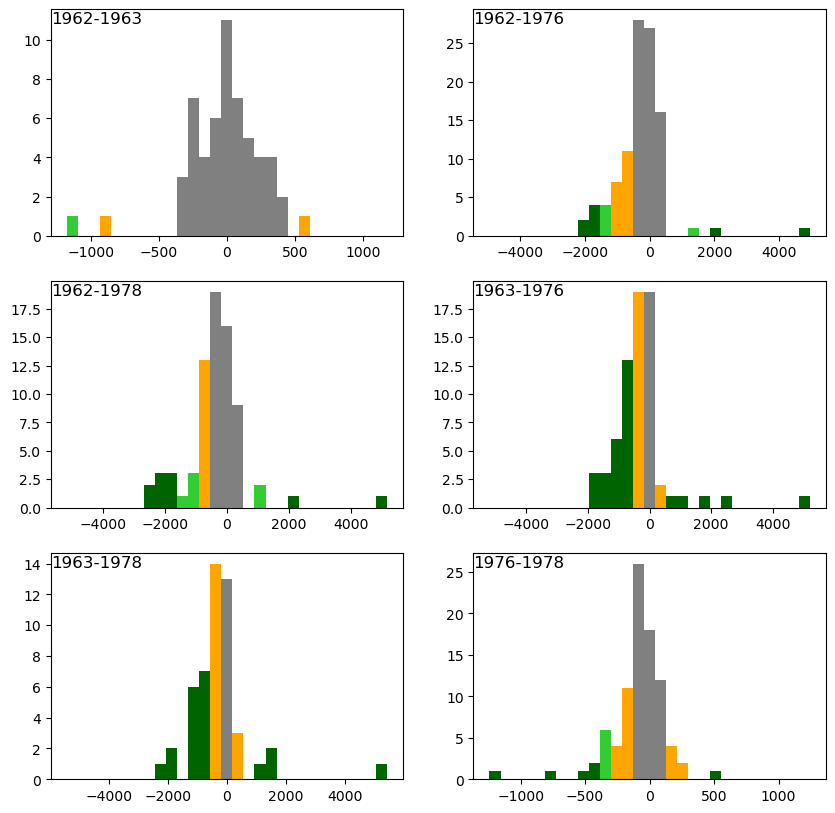

In [24]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(10, 10))

color_sigma = "orange"
color_2_sigma = "limegreen"
color_3_sigma = "darkgreen"
nbins = 30

years = (1962, 1963)
d = results_box.loc[results_box.years == years].mean_distance
N, bins, patches = axs[0, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2  # shift bins to the center
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[0, 0].set_title(f"{years[0]}-{years[1]}", y=0.9, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1962, 1976)
d = results_box.loc[results_box.years == years].mean_distance
N, bins, patches = axs[0, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[0, 1].set_title(f"{years[0]}-{years[1]}", y=0.9, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1962, 1978)
d = results_box.loc[results_box.years == years].mean_distance
N, bins, patches = axs[1, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[1, 0].set_title(f"{years[0]}-{years[1]}", y=0.9, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1963, 1976)
d = results_box.loc[results_box.years == years].mean_distance
N, bins, patches = axs[1, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[1, 1].set_title(f"{years[0]}-{years[1]}", y=0.9, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1963, 1978)
d = results_box.loc[results_box.years == years].mean_distance
N, bins, patches = axs[2, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[2, 0].set_title(f"{years[0]}-{years[1]}", y=0.9, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1976, 1978)
d = results_box.loc[results_box.years == years].mean_distance
N, bins, patches = axs[2, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[2, 1].set_title(f"{years[0]}-{years[1]}", y=0.9, loc="left")
print(d.shape[0], d.mean(), d.std())
fig.savefig("images/results_distances_distributions_box_big.png", bbox_inches="tight")

In [25]:
# list of surges and retreats

surges_box = pd.DataFrame(
    [],
    columns=["front_id", "years", "mean_distance", "uncertainty"]
)

retreats_box = pd.DataFrame(
    [],
    columns=["front_id", "years", "mean_distance", "uncertainty"]
)

for years in [(1962, 1963), (1962, 1976), (1962, 1978), (1963, 1976), (1963, 1978), (1976, 1978)]:
    # print("years :", years)
    sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]
    res = results_box.where(results_box.loc[results_box.years == years, "mean_distance"].apply(lambda x: np.abs(x) >= 2 * sigma)).dropna().loc[:, ["front_id", "years", "mean_distance", "uncertainty"]]
    # print(res)
    surges_1 = res.where(res.mean_distance.apply(lambda x: x >= 0)).dropna()
    retreats_1 = res.where(res.mean_distance.apply(lambda x: x < 0)).dropna()
    if not surges_1.empty:
        surges_box = pd.concat([surges_box, surges_1])
    if not retreats_1.empty:
        retreats_box = pd.concat([retreats_box, retreats_1])
        
surges_box

C:\Users\loris\AppData\Local\Temp\ipykernel_4536\3083962847.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  retreats_box = pd.concat([retreats_box, retreats_1])
C:\Users\loris\AppData\Local\Temp\ipykernel_4536\3083962847.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  surges_box = pd.concat([surges_box, surges_1])


,front_id,years,mean_distance,uncertainty
113,56,"(1962, 1976)",1281.064771,1021.819945
254,122,"(1962, 1976)",4936.214159,1021.819945
307,121,"(1962, 1976)",2153.329321,1021.819945
114,56,"(1962, 1978)",1118.781515,1022.952589
255,122,"(1962, 1978)",5174.801442,1022.952589
308,121,"(1962, 1978)",2279.420071,1022.952589
115,56,"(1963, 1976)",1159.852106,468.277695
194,91,"(1963, 1976)",775.398523,468.277695
256,122,"(1963, 1976)",5198.308320,468.277695
398,92,"(1963, 1976)",1823.102178,468.277695


In [26]:
retreats_box

,front_id,years,mean_distance,uncertainty
419,105,"(1962, 1963)",-1175.502816,1091.421092
40,37,"(1962, 1976)",-1401.692189,1021.819945
101,54,"(1962, 1976)",-1542.028761,1021.819945
223,161,"(1962, 1976)",-1023.359882,1021.819945
287,42,"(1962, 1976)",-1180.570938,1021.819945
...,...,...,...,...
391,73,"(1976, 1978)",-386.318624,272.976189
394,74,"(1976, 1978)",-381.492736,272.976189
400,92,"(1976, 1978)",-383.159906,272.976189
403,93,"(1976, 1978)",-805.205309,272.976189


In [27]:
# list of all fronts that either surged or retreated with >95% accuracy
len(surges_box.front_id.unique()), surges_box.front_id.unique(), len(retreats_box.front_id.unique()), retreats_box.front_id.unique()

(8,
 array([56, 122, 121, 91, 92, 93, 120, 165], dtype=object),
 48,
 array([105, 37, 54, 161, 42, 109, 62, 76, 73, 74, 75, 95, 106, 154, 144,
        4, 28, 38, 41, 50, 51, 52, 53, 58, 180, 111, 141, 138, 139, 140,
        178, 142, 160, 2, 96, 97, 98, 33, 46, 49, 116, 124, 34, 43, 60, 92,
        93, 89], dtype=object))

## Comparison manual / box method

In [28]:
for i in results_box.index.values:
    front_id, year1, year2 = results_box.loc[i][["front_id", "year_1", "year_2"]]
    for j in results.index.values:
        front_id_2, year1_2, year2_2 = results_box.loc[j][["front_id", "year_1", "year_2"]]
        if (front_id == front_id_2) and (year1 == year1_2) and (year2 == year2_2):
            results_box.loc[i, "mean_distance_2"] = results.loc[j, "mean_distance"]
            results_box.loc[i, "uncertainty_2"] = results.loc[j, "uncertainty"]
            
results_box

,front_id,year_1,year_2,years,distance,mean_distance,uncertainty,mean_distance_2,uncertainty_2
0,3,1963,1976,"(1963, 1976)","[-341.26830933591924, -463.03829475751604]",-402.153302,468.277695,-241.275979,1091.421092
1,4,1963,1976,"(1963, 1976)","[-501.3441551864909, -545.3417011649898, -367....",-776.636692,468.277695,-924.789543,1021.819945
2,25,1962,1963,"(1962, 1963)","[104.29363221683396, 260.1996766181235]",182.246654,1091.421092,-664.223629,468.277695
3,25,1962,1976,"(1962, 1976)","[251.13957302078396, 269.4042203817791, 81.303...",278.568870,1021.819945,-39.310605,1091.421092
4,25,1963,1976,"(1963, 1976)","[146.84594080395, 165.11058816494514, -22.9898...",96.322216,468.277695,148.672829,1021.819945
...,...,...,...,...,...,...,...,...,...
435,65,1976,1978,"(1976, 1978)",[-114.31890299647765],-114.318903,272.976189,-153.444729,272.976189
436,66,1976,1978,"(1976, 1978)",[-85.73270102390168],-85.732701,272.976189,-72.567047,272.976189
437,72,1976,1978,"(1976, 1978)",[-36.90731420880558],-36.907314,272.976189,-33.726691,272.976189
438,79,1976,1978,"(1976, 1978)",[-87.25323145609863],-87.253231,272.976189,-75.400310,272.976189


In [29]:
results_cross = results_box.loc[:, ["front_id", "year_1", "year_2", "years", "mean_distance", "mean_distance_2", "uncertainty", "uncertainty_2"]]
results_cross.columns = ["front_id", "year_1", "year_2", "years", "mean_distance_box", "mean_distance_manual", "uncertainty_box", "uncertainty_manual"]
results_cross.dropna(inplace=True)
results_cross

,front_id,year_1,year_2,years,mean_distance_box,mean_distance_manual,uncertainty_box,uncertainty_manual
0,3,1963,1976,"(1963, 1976)",-402.153302,-241.275979,468.277695,1091.421092
1,4,1963,1976,"(1963, 1976)",-776.636692,-924.789543,468.277695,1021.819945
2,25,1962,1963,"(1962, 1963)",182.246654,-664.223629,1091.421092,468.277695
3,25,1962,1976,"(1962, 1976)",278.568870,-39.310605,1021.819945,1091.421092
4,25,1963,1976,"(1963, 1976)",96.322216,148.672829,468.277695,1021.819945
...,...,...,...,...,...,...,...,...
434,82,1976,1978,"(1976, 1978)",-136.123419,-91.974519,272.976189,272.976189
435,65,1976,1978,"(1976, 1978)",-114.318903,-153.444729,272.976189,272.976189
436,66,1976,1978,"(1976, 1978)",-85.732701,-72.567047,272.976189,272.976189
437,72,1976,1978,"(1976, 1978)",-36.907314,-33.726691,272.976189,272.976189


In [30]:
scipy.stats.linregress(
    results_cross.mean_distance_box,
    results_cross.mean_distance_manual
)

LinregressResult(slope=0.3658408618648422, intercept=-42.74411748948775, rvalue=0.5431427134089073, pvalue=4.7096284220368577e-35, stderr=0.02705396100380733, intercept_stderr=22.40278651704487)

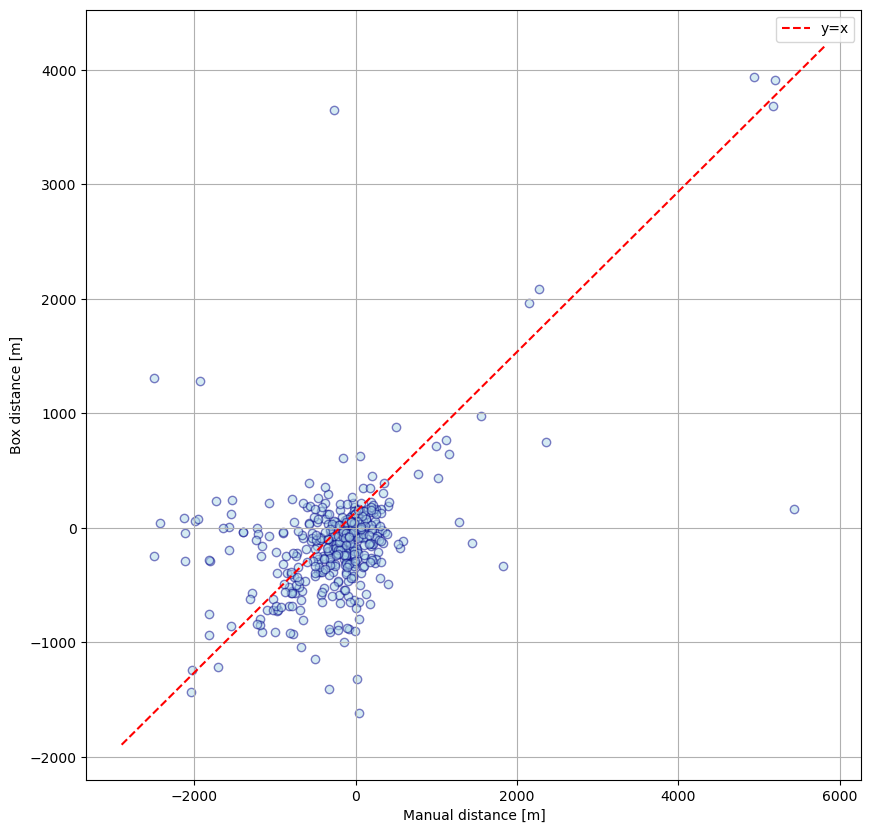

In [31]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(results_cross.mean_distance_box, results_cross.mean_distance_manual, color="lightblue", edgecolor="darkblue", alpha=0.5)
ax.plot(ax.get_xlim(), ax.get_ylim(), color="red", linestyle="--", label="y=x")
ax.grid()
ax.legend()
ax.set_xlabel("Manual distance [m]")
ax.set_ylabel("Box distance [m]")
fig.savefig("images/results_cross_distances.png", bbox_inches="tight")